## Eksperymenty z NLP i językiem polskim - NER & Klasyfikacja

W NER wykorzystano model pl_core_news_lg i spacy (https://spacy.io/models/pl#pl_core_news_lg)
Inne źródła: materiały z zajęć (Text Mining @ PW, 2021)

In [1]:
# ! pip install spacy
# ! python -m spacy download pl_core_news_lg

In [3]:
import pandas as pd
import spacy
from spacy import displacy
from spacy.lang.pl.examples import sentences
from tqdm import tqdm
import numpy as np
import shutil
import requests
from pathlib import Path
import collections
from pprint import pprint

Ustawienia

In [4]:
dataframe_file_path = './data/big/dfnlp2400_1642721436.parquet'
df = pd.read_parquet(dataframe_file_path)
portals = ['bankier', 'naszdziennik', 'niebezpiecznik', 'onet', 'pcworld', 'plotek', 'pr24', 'tvn24']
df

,title,title_int,lead_text,lead_text_int,link,text,when_published,author,source,portal
0,Spadki na Wall Street koniec sesji. Nasdaq znó...,Spadki na Wall Street koniec sesji. Nasdaq znó...,Środowa sesja na Wall Street zakończyła się sp...,Środowa sesja na Wall Street zakończyła się sp...,https://www.bankier.pl/wiadomosc/Wall-Street-w...,Dow Jones Industrial na zamknięciu spadł o 339...,2022-01-19 22:12:00,kkr/ pr/,PAP Biznes,bankier
1,Specjaliści od cyberbezpieczeństwa w administr...,Specjaliści od cyberbezpieczeństwa w administr...,Rada Ministrów przyjęła w środę rozporządzenie...,Rada Ministrów przyjęła w środę rozporządzenie...,https://www.bankier.pl/wiadomosc/Specjalisci-o...,"Jak wyjaśniono, rozporządzenie określa zasady ...",2022-01-19 20:18:00,pif/ mk/,PAP,bankier
2,Mark Brzezinski oficjalnie zaprzysiężony na am...,Mark Brzezinski oficjalnie zaprzysiężony na am...,Wiceprezydent USA Kamala Harris oficjalnie zap...,Wiceprezydent USA Kamala Harris oficjalnie zap...,https://www.bankier.pl/wiadomosc/Mark-Brzezins...,Podczas ceremonii w budynku Eisenhowera mieszc...,2022-01-19 20:17:00,osk/ tebe/,PAP,bankier
3,Portugalia wszczyna śledztwo w sprawie przyzna...,Portugalia wszczyna śledztwo w sprawie przyzna...,Prokuratura generalna Portugalii wszczęła w śr...,Prokuratura generalna Portugalii wszczęła w śr...,https://www.bankier.pl/wiadomosc/Portugalia-ws...,"Prokuratura generalna wyjaśniła, że przedmiote...",2022-01-19 20:11:00,zat/ mal/,PAP,bankier
4,Szef MSZ Zbigniew Rau zakażony koronawirusem,Szef MSZ Zbigniew Rau zakażony koronawirusem,Minister spraw zagranicznych Zbigniew Rau uzys...,Minister spraw zagranicznych Zbigniew Rau uzys...,https://www.bankier.pl/wiadomosc/Szef-MSZ-Zbig...,"""Z uwagi na pozytywny wynik testu na SARS-CoV-...",2022-01-19 20:05:00,wni/ mok/,PAP,bankier
...,...,...,...,...,...,...,...,...,...,...
2395,Możliwe osiągnięcie stanów ostrzegawczych. Ost...,Możliwe osiągnięcie stanów ostrzegawczych. Ost...,Instytut Meteorologii i Gospodarki Wodnej wyda...,Poziom wód w rejonie Żuław i Zalewu Wiślanego ...,https://tvn24.pl/tvnmeteo/prognoza/imgw-alerty...,"""W związku z prognozowanym silnym, sztormowym ...",2022-01-15 06:55:00,ps,"PAP, IMGW",tvn24
2396,NFZ obcina stawki za testy na koronawirusa. Cz...,NFZ obcina stawki za testy na obecność koronaw...,"Materiał magazynu ""Polska i Świat"".",Narodowy Fundusz Zdrowia obciął stawki na poje...,https://tvn24.pl/polska/koronawirus-w-polsce-n...,"Najpierw wymaz, a później badanie w budynku tu...",2022-01-15 06:32:00,AleksandraKąkol,TVN24,tvn24
2397,Pogoda na dziś. Termometry pokażą od 2 do 5 st...,Pogoda na dziś - sobota 15.01. Zachmurzenie bę...,W sobotę w całym kraju odczujemy chłód.,Pogoda na dziś. Sobota (15.01) upłynie pod zna...,https://tvn24.pl/tvnmeteo/prognoza/pogoda-na-d...,Na sobotę prognozowane jest zmienne zachmurzen...,2022-01-15 02:00:00,anw,tvnmeteo.pl,tvn24
2398,"""Polskie prawo w sprawie inwigilacji nie odpow...",Rzecznik Praw Obywatelskich interweniuje u pre...,RPO interweniuje u premiera.,Rzecznik Praw Obywatelskich Marcin Wiącek wyst...,https://tvn24.pl/polska/pegasus-rzecznik-praw-...,OGLĄDAJ TVN24 W INTERNECIE W TVN24 GO Marcin W...,2022-01-14 22:49:00,mjz//rzw,PAP,tvn24


Kilka dodatkowych zmian:

In [5]:
# opcja: dodanie kolumny lead_and_text zawierającej połaczenie kolumn lead_text oraz text
df['lead_and_text'] = df.apply(lambda x: x.lead_text if len(x.lead_text) >= len(x.lead_text_int) else x.lead_text_int, axis=1) + ' ' + df.text

Konfiguracja NLP i spacy

In [6]:
nlp = spacy.load("pl_core_news_lg")

In [6]:
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'parser', 'tagger', 'attribute_ruler', 'lemmatizer', 'ner']


### Czyszczenie korpusu - lematyzacja

In [7]:
def clean_with_spacy(spacy_doc):
    tokens_cl = [(str(token.lemma_.lower())) for token in spacy_doc
                 if not any([token.is_punct, token.is_stop, token.like_num, token.is_currency, token.like_email, not(token.is_alpha)])]
    return " ".join(tokens_cl).strip()

In [8]:
def spacy_pipeline(dataframe, text_col):
    text_cleaned = []
    for doc in tqdm(nlp.pipe(dataframe[text_col])):
        text_cleaned.append(clean_with_spacy(doc))
    return text_cleaned

In [98]:
%%time
df["clean_title"] = spacy_pipeline(df, "title")

2400it [00:05, 476.83it/s]

Wall time: 5.04 s


In [99]:
%%time
df["clean_lead_text"] = spacy_pipeline(df, "lead_text")

2400it [00:10, 221.45it/s]

Wall time: 10.8 s


In [100]:
%%time
df["clean_lead_and_text"] = spacy_pipeline(df, "lead_and_text")

2400it [04:13,  9.48it/s]

Wall time: 4min 13s


In [11]:
i = np.random.randint(low=0, high=len(df.index))
print(f'lead_text[{i}]:\n  {df.iloc[i]["lead_text"]}')
print(f'clean_lead_text[{i}]:\n  {df.iloc[i]["clean_lead_text"]}')
# print(f'text[{i}]:\n  {df.iloc[i]["text"]}')
# print(f'clean_text[{i}]:\n  {df.iloc[i]["clean_text"]}')

lead_text[1027]:
  Wiceminister edukacji wyraził obawy, że mogą pojawić się zajęcia w szkołach, które "wychowują bandytów". W reakcji na to Joanna Scheuring-Wielgus pokazała na tablecie zdjęcie dzieci Tomasza Rzymkowskiego, które swego czasu polityk udostępnił na Twitterze. Na fotografii widać, jak małe dzieci "celują" palcami do manekina ubranego w strój bolszewika. — Czy pan uważa, że dzieci powinny celować w manekina. To jest wspaniałe? — pytała posłanka Lewicy w programie "7. Dzień Tygodnia".
clean_lead_text[1027]:
  wiceminister edukacja wyrazić obawa pojawić zajęcie szkoła wychowywać bandyta reakcja joanna scheuring wielgus pokazać tablet zdjęcie dziecko tomasz rzymkowski swego czas polityka udostępnić twitterze fotografia widać mały dziecko celować palec manekin ubrany strój bolszewik uważać dziecko powinny celować manekin wspaniały pytać posłanek lewicy program dzienie tydzień


### Named Entity Recognition

#### NER - eksperyment 1
Rozpoznawanie Bytów Nazwanych dla losowego tekstu artykułu

In [28]:
# Named Entity Recognition for random article lead_text
i = np.random.randint(low=0, high=len(df.index))
doc = nlp(df.iloc[i]['text'])
print(f'index: {i}\ntitle: {df.iloc[i].title}')
rows = []
for ent in doc.ents:
    rows.append ([ent.text, ent.start_char, ent.end_char, ent.label_])

example_result = pd.DataFrame(rows, columns = ["TEXT", "START", "END", "LABEL"])
displacy.render(doc, style="ent")

index: 373
title: Murem za kurator Nowak


In [30]:
example_result


,TEXT,START,END,LABEL
0,Katolicka Archidiecezji Częstochowskiej,6,45,orgName
1,małopolskiej,62,74,placeName
2,Nowak”.,139,146,persName


In [24]:
# dobre tylko, gdy chcemy pokazać kilka krótkich zdań, w przeciwnym wypadku chaos i zjedzenie pamięci komputera
# sentence_spans = list(doc.sents)
# displacy.render(sentence_spans, style="dep")

In [29]:
# NLP for random article title - dependencies for title
doc2 = nlp(df.iloc[i]['title'])
print(f'index: {i}\ntitle: {df.iloc[i].title}')

displacy.render(doc2, style='dep')

index: 373
title: Murem za kurator Nowak


Wnioski:
1. Bardzo wiele bytów nazwanych zostało prawidłowo rozpoznane
2. Część bytów nie została oznaczona (co ciekawe - niektóre nazwy występują w tekście o wiele więcej razy niż oznaczone rozpoznania)
3. Czasami nieprawidłowo został rozpoznany typ bytu (np. aplikacja Pegasus jest rozpoznawana jako organizacja)

#### NER - eksperyment 2
Statystyki dla poszczególnych portali i dla wszystkich razem dla kolumn title oraz lead_and_text

In [16]:
# create dataframes to store data about Named Entities in titles
titles_ner_freq_dfs = dict()
lead_and_text_ner_freq_dfs = dict()
dtypes = {'text': pd.Series(dtype='str'),
          'label': pd.Series(dtype='str'),
          'frequency': pd.Series(dtype='int')}

# pd.DataFrame(dtypes)
titles_ner_freq_dfs['full'] = None
lead_and_text_ner_freq_dfs['full'] = None
for portal in portals:
    titles_ner_freq_dfs[portal] = None
    lead_and_text_ner_freq_dfs[portal] = None

Statystyki NER dla wszystkich tytułów z bankiera

In [17]:
# named entities - how many times these name entities were used in titles?
data = []

for title in df.where(df.portal=='bankier').dropna().title.tolist():
    doc = nlp(title)
    for entity in doc.ents:
        data.append((entity.text, entity.label_))

counter=collections.Counter(data)

counter.most_common()

[(('Polsce', 'placeName'), 10),
 (('Polski', 'placeName'), 9),
 (('PGNiG', 'orgName'), 7),
 (('Polskiego', 'placeName'), 6),
 (('NIK', 'orgName'), 6),
 (('PGE', 'orgName'), 5),
 (('Ukrainy', 'placeName'), 5),
 (('Tusk', 'persName'), 5),
 (('Chin', 'placeName'), 4),
 (('Polskim', 'placeName'), 4),
 (('ZUS', 'orgName'), 4),
 (('NBP', 'orgName'), 4),
 (('Polska', 'placeName'), 4),
 (('KE', 'orgName'), 4),
 (('UE', 'orgName'), 4),
 (('Polacy', 'placeName'), 4),
 (('Polaków', 'placeName'), 4),
 (('USA', 'placeName'), 3),
 (('PiS', 'orgName'), 3),
 (('Kukiz', 'persName'), 3),
 (('Kruk', 'persName'), 3),
 (('RPP', 'orgName'), 3),
 (('Wielkiej Brytanii', 'placeName'), 3),
 (('UOKiK', 'orgName'), 3),
 (('polskich', 'placeName'), 3),
 (('Müller', 'persName'), 2),
 (('PO', 'orgName'), 2),
 (('Tonga', 'placeName'), 2),
 (('Czechach', 'placeName'), 2),
 (('BM mBanku', 'orgName'), 2),
 (('KAS', 'orgName'), 2),
 (('Moskwie', 'placeName'), 2),
 (('Norwegii', 'placeName'), 2),
 (('Pekinie', 'placeName'

In [31]:
len(counter.keys())

2693

Lista najpopularniejszych bytów nazwanych w tytułach na portalu bankier zawiera wiele elementów, które można uznać za duplikaty (np. Polsce, Polski, Polskiego, Polska, Polskim).
Do kolejnych podsumowań użyjemy wyników lematyzacji

In [18]:
# named entities - how many times these lemma were used in titles?
data = []

for title in df.where(df.portal=='bankier').dropna().title.tolist():
    doc = nlp(title)
    for entity in doc.ents:
        data.append((entity.lemma_.lower(), entity.label_))

counter=collections.Counter(data)
counter.most_common()

[(('polska', 'placeName'), 21),
 (('polski', 'placeName'), 18),
 (('ukraina', 'placeName'), 11),
 (('pgnig', 'orgName'), 7),
 (('chiny', 'placeName'), 6),
 (('nik', 'orgName'), 6),
 (('pge', 'orgName'), 5),
 (('wielki brytania', 'placeName'), 5),
 (('tusk', 'persName'), 5),
 (('czechy', 'placeName'), 4),
 (('zus', 'orgName'), 4),
 (('nbp', 'orgName'), 4),
 (('ke', 'orgName'), 4),
 (('ue', 'orgName'), 4),
 (('polak', 'placeName'), 4),
 (('polaki', 'placeName'), 4),
 (('usa', 'placeName'), 3),
 (('rosja', 'placeName'), 3),
 (('pis', 'orgName'), 3),
 (('kukiz', 'persName'), 3),
 (('kruk', 'persName'), 3),
 (('moskwa', 'placeName'), 3),
 (('rpp', 'orgName'), 3),
 (('niemiec', 'placeName'), 3),
 (('brejza', 'persName'), 3),
 (('uokik', 'orgName'), 3),
 (('johnson', 'persName'), 3),
 (('portugalia', 'placeName'), 2),
 (('müller', 'persName'), 2),
 (('po', 'orgName'), 2),
 (('tongo', 'placeName'), 2),
 (('bm mbanku', 'orgName'), 2),
 (('kas', 'orgName'), 2),
 (('norwegia', 'placeName'), 2),
 

Podsumowanie dla tytułów dla wszystkich portali (długa operacja)

In [19]:
%%time
for portal_name in titles_ner_freq_dfs.keys():
    data = []
    if portal_name == 'full':
        texts = df.dropna().title.tolist()
    else:
        texts = df.where(df.portal==portal_name).dropna().title.tolist()

    pbar = tqdm(total=len(texts))
    for title in texts:
        doc = nlp(title)
        for entity in doc.ents:
            data.append((entity.lemma_.lower(), entity.label_))
        pbar.update(1)

    counter=collections.Counter(data)
    titles_ner_freq_dfs[portal_name] = counter
    pbar.close()

100%|██████████| 300/300 [00:02<00:00, 130.26it/s]

Wall time: 34.9 s


In [20]:
%%time
for portal_name in lead_and_text_ner_freq_dfs.keys():
    data = []
    if portal_name == 'full':
        texts = df.dropna().lead_and_text.tolist()
    else:
        texts = df.where(df.portal==portal_name).dropna().lead_and_text.tolist()

    pbar = tqdm(total=len(texts))
    for title in texts:
        doc = nlp(title)
        for entity in doc.ents:
            data.append((entity.lemma_.lower(), entity.label_))
        pbar.update(1)

    counter=collections.Counter(data)
    lead_and_text_ner_freq_dfs[portal_name] = counter
    pbar.close()

100%|██████████| 300/300 [00:21<00:00, 13.98it/s]

Wall time: 9min 36s


In [37]:
print('Najpopularniejsze byty nazwane występujące w tytułach artykułów')
for portal_name in titles_ner_freq_dfs.keys():
    print(f'portal: {portal_name}, korpus: {len(titles_ner_freq_dfs[portal_name].most_common())}')
    pprint(titles_ner_freq_dfs[portal_name].most_common(10))

Najpopularniejsze byty nazwane występujące w tytułach artykułów
portal: full, korpus: 1272
[(('2022', 'date'), 121),
 (('polska', 'placeName'), 119),
 (('01.', 'date'), 114),
 (('polski', 'placeName'), 79),
 (('19.', 'date'), 44),
 (('pis', 'orgName'), 42),
 (('18.', 'date'), 34),
 (('„naszym dziennik”', 'geogName'), 33),
 (('rada medyczny', 'orgName'), 32),
 (('tusk', 'persName'), 22)]
portal: bankier, korpus: 287
[(('polska', 'placeName'), 21),
 (('polski', 'placeName'), 18),
 (('ukraina', 'placeName'), 11),
 (('pgnig', 'orgName'), 7),
 (('chiny', 'placeName'), 6),
 (('nik', 'orgName'), 6),
 (('pge', 'orgName'), 5),
 (('wielki brytania', 'placeName'), 5),
 (('tusk', 'persName'), 5),
 (('czechy', 'placeName'), 4)]
portal: naszdziennik, korpus: 72
[(('„naszym dziennik”', 'geogName'), 33),
 (('grudzień', 'date'), 10),
 (('polska', 'placeName'), 6),
 (('polski', 'placeName'), 4),
 (('imgw', 'orgName'), 4),
 (('styczeń', 'date'), 4),
 (('putin', 'persName'), 3),
 (('ipn', 'orgName'), 2),


In [38]:
print('Najpopularniejsze byty nazwane występujące w treści artykułów')
for portal_name in lead_and_text_ner_freq_dfs.keys():
    print(f'portal: {portal_name}, korpus: {len(lead_and_text_ner_freq_dfs[portal_name].most_common())}')
    pprint(lead_and_text_ner_freq_dfs[portal_name].most_common(10))

Najpopularniejsze byty nazwane występujące w treści artykułów
portal: full, korpus: 18016
[(('polska', 'placeName'), 2142),
 (('polski', 'placeName'), 1563),
 (('2021', 'date'), 989),
 (('appel', 'orgName'), 785),
 (('01.', 'date'), 651),
 (('2022', 'date'), 628),
 (('pis', 'orgName'), 615),
 (('styczeń', 'date'), 603),
 (('google', 'orgName'), 599),
 (('lipiec', 'date'), 490)]
portal: bankier, korpus: 2931
[(('polska', 'placeName'), 318),
 (('polski', 'placeName'), 239),
 (('pap', 'orgName'), 150),
 (('ukraina', 'placeName'), 121),
 (('nik', 'orgName'), 92),
 (('sejm', 'orgName'), 82),
 (('grudzień', 'date'), 80),
 (('pis', 'orgName'), 70),
 (('pgnig', 'orgName'), 67),
 (('usa', 'placeName'), 66)]
portal: naszdziennik, korpus: 2807
[(('lipiec', 'date'), 446),
 (('polska', 'placeName'), 381),
 (('kwiecień', 'date'), 370),
 (('styczeń', 'date'), 357),
 (('sierpień', 'date'), 341),
 (('luty', 'date'), 338),
 (('czerwiec', 'date'), 337),
 (('maj', 'date'), 336),
 (('wrzesień', 'date'), 26

In [22]:
lead_and_text_ner_freq_dfs['full'].most_common(1)

[(('polska', 'placeName'), 2142)]

### Czy jesteśmy w stanie zgadnąć z jakiego portalu pochodzi artykuł na podstawie nagłówka?


#### Próba ze Spacy - niestety nieudana na języku polskim (kod działa na angielskim)

In [20]:
# dodajmy do naszego df kolumnę portal_id oznaczającą kategorię liczbową
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['portal_id'] = LE.fit_transform(df['portal'])

In [21]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [73]:
import string
from spacy.lang.pl.stop_words import STOP_WORDS
from spacy.lang.pl import Polish

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("pl_core_news_lg")
stop_words = spacy.lang.pl.stop_words.STOP_WORDS

# Load Polish tokenizer, tagger, parser, NER and word vectors
parser = Polish()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [74]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [75]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [76]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [77]:
df

,title,title_int,lead_text,lead_text_int,link,text,when_published,author,source,portal,lead_and_text,clean_lead_text,portal_id
0,Spadki na Wall Street koniec sesji. Nasdaq znó...,Spadki na Wall Street koniec sesji. Nasdaq znó...,Środowa sesja na Wall Street zakończyła się sp...,Środowa sesja na Wall Street zakończyła się sp...,https://www.bankier.pl/wiadomosc/Wall-Street-w...,Dow Jones Industrial na zamknięciu spadł o 339...,2022-01-19 22:12:00,kkr/ pr/,PAP Biznes,bankier,Środowa sesja na Wall Street zakończyła się sp...,środowy sesja walla street zakończyć spadek wz...,0
1,Specjaliści od cyberbezpieczeństwa w administr...,Specjaliści od cyberbezpieczeństwa w administr...,Rada Ministrów przyjęła w środę rozporządzenie...,Rada Ministrów przyjęła w środę rozporządzenie...,https://www.bankier.pl/wiadomosc/Specjalisci-o...,"Jak wyjaśniono, rozporządzenie określa zasady ...",2022-01-19 20:18:00,pif/ mk/,PAP,bankier,Rada Ministrów przyjęła w środę rozporządzenie...,rado minister przyjąć środa rozporządzenie spr...,0
2,Mark Brzezinski oficjalnie zaprzysiężony na am...,Mark Brzezinski oficjalnie zaprzysiężony na am...,Wiceprezydent USA Kamala Harris oficjalnie zap...,Wiceprezydent USA Kamala Harris oficjalnie zap...,https://www.bankier.pl/wiadomosc/Mark-Brzezins...,Podczas ceremonii w budynku Eisenhowera mieszc...,2022-01-19 20:17:00,osk/ tebe/,PAP,bankier,Wiceprezydent USA Kamala Harris oficjalnie zap...,wiceprezydent usa kamala harris oficjalnie zap...,0
3,Portugalia wszczyna śledztwo w sprawie przyzna...,Portugalia wszczyna śledztwo w sprawie przyzna...,Prokuratura generalna Portugalii wszczęła w śr...,Prokuratura generalna Portugalii wszczęła w śr...,https://www.bankier.pl/wiadomosc/Portugalia-ws...,"Prokuratura generalna wyjaśniła, że przedmiote...",2022-01-19 20:11:00,zat/ mal/,PAP,bankier,Prokuratura generalna Portugalii wszczęła w śr...,prokuratura generalny portugalia wszcząć środa...,0
4,Szef MSZ Zbigniew Rau zakażony koronawirusem,Szef MSZ Zbigniew Rau zakażony koronawirusem,Minister spraw zagranicznych Zbigniew Rau uzys...,Minister spraw zagranicznych Zbigniew Rau uzys...,https://www.bankier.pl/wiadomosc/Szef-MSZ-Zbig...,"""Z uwagi na pozytywny wynik testu na SARS-CoV-...",2022-01-19 20:05:00,wni/ mok/,PAP,bankier,Minister spraw zagranicznych Zbigniew Rau uzys...,minister sprawa zagraniczny zbigniew rau uzysk...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,Możliwe osiągnięcie stanów ostrzegawczych. Ost...,Możliwe osiągnięcie stanów ostrzegawczych. Ost...,Instytut Meteorologii i Gospodarki Wodnej wyda...,Poziom wód w rejonie Żuław i Zalewu Wiślanego ...,https://tvn24.pl/tvnmeteo/prognoza/imgw-alerty...,"""W związku z prognozowanym silnym, sztormowym ...",2022-01-15 06:55:00,ps,"PAP, IMGW",tvn24,Poziom wód w rejonie Żuław i Zalewu Wiślanego ...,instytut meteorologia gospodarka wodny wydać a...,7
2396,NFZ obcina stawki za testy na koronawirusa. Cz...,NFZ obcina stawki za testy na obecność koronaw...,"Materiał magazynu ""Polska i Świat"".",Narodowy Fundusz Zdrowia obciął stawki na poje...,https://tvn24.pl/polska/koronawirus-w-polsce-n...,"Najpierw wymaz, a później badanie w budynku tu...",2022-01-15 06:32:00,AleksandraKąkol,TVN24,tvn24,Narodowy Fundusz Zdrowia obciął stawki na poje...,materiał magazyn polska świat,7
2397,Pogoda na dziś. Termometry pokażą od 2 do 5 st...,Pogoda na dziś - sobota 15.01. Zachmurzenie bę...,W sobotę w całym kraju odczujemy chłód.,Pogoda na dziś. Sobota (15.01) upłynie pod zna...,https://tvn24.pl/tvnmeteo/prognoza/pogoda-na-d...,Na sobotę prognozowane jest zmienne zachmurzen...,2022-01-15 02:00:00,anw,tvnmeteo.pl,tvn24,Pogoda na dziś. Sobota (15.01) upłynie pod zna...,sobota cały kraj odczuć chłód,7
2398,"""Polskie prawo w sprawie inwigilacji nie odpow...",Rzecznik Praw Obywatelskich interweniuje u pre...,RPO interweniuje u premiera.,Rzecznik Praw Obywatelskich Marcin Wiącek wyst...,https://tvn24.pl/polska/pegasus-rzecznik-praw-...,OGLĄDAJ TVN24 W INTERNECIE W TVN24 GO Marcin W...,

In [12]:
data = [['Kruk planuje wyemitować obligacje.', 0], ['Szef MSZ Zbigniew RAU został ojcem po raz trzeci.', 1], ['Słynny serbski tenisista NovaK Djoković wrócił już do domu.', 2]]
test_df = pd.DataFrame(data, columns = ['lead_and_text', 'portal_id'])

In [13]:
# podzielmy dane na zbiory uczący i testowy
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(df['lead_and_text'], df['portal_id'], test_size=0.3333, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(test_df['lead_and_text'], test_df['portal_id'], test_size=0.3333, random_state=42)

In [14]:
print(f'Wielkość zbioru x_train: {len(x_train)}')
print(f'Wielkość zbioru y_train: {len(y_train)}')
print(f'Wielkość zbioru x_test: {len(x_test)}')
print(f'Wielkość zbioru y_test: {len(y_test)}')

Wielkość zbioru x_train: 2
Wielkość zbioru y_train: 2
Wielkość zbioru x_test: 1
Wielkość zbioru y_test: 1


In [15]:
x_test

0    Kruk planuje wyemitować obligacje.
Name: lead_and_text, dtype: object

In [17]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(x_train,y_train)

NameError: name 'Pipeline' is not defined

#### Szybki model ze Sklearn - Adaptive Boost, treść artykułów, Adaptive Boost + Count Vectorizer
wynik: bardzo mylący, zasadniczo słaby

C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       104
           1      0.000     0.000     0.000       111
           2      0.883     0.989     0.933        92
           3      0.000     0.000     0.000        96
           4      0.937     0.890     0.913       100
           5      0.000     0.000     0.000        96
           6      0.154     0.958     0.266        95
           7      0.000     0.000     0.000       106

    accuracy                          0.339       800
   macro avg      0.247     0.355     0.264       800
weighted avg      0.237     0.339     0.253       800



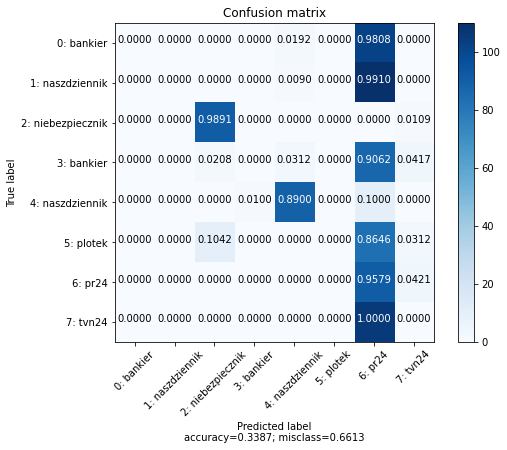

In [23]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier

x_train, x_test, y_train, y_test = train_test_split(df['lead_and_text'], df['portal_id'], test_size=0.3333, random_state=42)


text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', AdaBoostClassifier()),
 ])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_test)
score = text_clf.score(x_test, y_test)

print(metrics.classification_report(y_test, y_pred,digits=3))
['bankier', 'naszdziennik', 'niebezpiecznik', 'onet', 'pcworld', 'plotek', 'pr24', 'tvn24']
confusion_matrix(y_test, y_pred)
plot_confusion_matrix.plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                                            target_names=['0: bankier', '1: naszdziennik', '2: niebezpiecznik', '3: bankier', '4: naszdziennik', '5: plotek', '6: pr24', '7: tvn24'])

In [26]:
import pickle
import sys

p = pickle.dumps(text_clf)
print(sys.getsizeof(p))

2515913


#### Szybki model ze Sklearn - SVM + TfidfTransformer, pełna treść artykułu
wynik: przyzwoity

              precision    recall  f1-score   support

           0      0.765     0.625     0.688       104
           1      0.906     0.523     0.663       111
           2      0.919     0.989     0.953        92
           3      0.663     0.719     0.690        96
           4      1.000     0.870     0.930       100
           5      0.913     0.990     0.950        96
           6      0.350     0.579     0.437        95
           7      0.770     0.726     0.748       106

    accuracy                          0.746       800
   macro avg      0.786     0.753     0.757       800
weighted avg      0.789     0.746     0.755       800



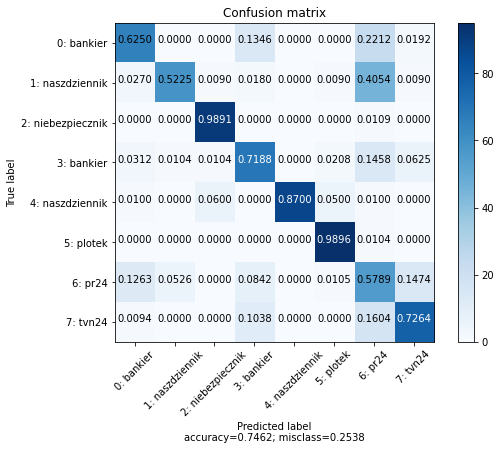

In [22]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier

x_train, x_test, y_train, y_test = train_test_split(df['lead_and_text'], df['portal_id'], test_size=0.3333, random_state=42)


text_clf = Pipeline([('vect', TfidfVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVC(decision_function_shape='ovr')),
 ])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_test)
score = text_clf.score(x_test, y_test)

print(metrics.classification_report(y_test, y_pred,digits=3))
['bankier', 'naszdziennik', 'niebezpiecznik', 'onet', 'pcworld', 'plotek', 'pr24', 'tvn24']
confusion_matrix(y_test, y_pred)
plot_confusion_matrix.plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                                            target_names=['0: bankier', '1: naszdziennik', '2: niebezpiecznik', '3: bankier', '4: naszdziennik', '5: plotek', '6: pr24', '7: tvn24'])

#### Szybki model ze Sklearn - SVM + TfidfTransformer, pełna treść artykułu po czyszczeniu ze spacy
wynik: przyzwoity, nie widać różnicy względem wersji nieoczyszczonej

              precision    recall  f1-score   support

           0      0.762     0.587     0.663       104
           1      0.929     0.586     0.718       111
           2      0.968     1.000     0.984        92
           3      0.631     0.729     0.676        96
           4      0.989     0.890     0.937       100
           5      0.922     0.979     0.949        96
           6      0.352     0.537     0.425        95
           7      0.692     0.698     0.695       106

    accuracy                          0.745       800
   macro avg      0.780     0.751     0.756       800
weighted avg      0.783     0.745     0.754       800



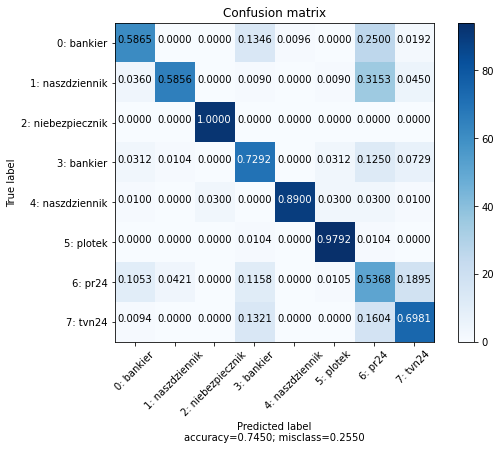

In [101]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier

x_train, x_test, y_train, y_test = train_test_split(df['clean_lead_and_text'], df['portal_id'], test_size=0.3333, random_state=42)


text_clf = Pipeline([('vect', TfidfVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVC(decision_function_shape='ovr')),
 ])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_test)
score = text_clf.score(x_test, y_test)

print(metrics.classification_report(y_test, y_pred,digits=3))
['bankier', 'naszdziennik', 'niebezpiecznik', 'onet', 'pcworld', 'plotek', 'pr24', 'tvn24']
confusion_matrix(y_test, y_pred)
plot_confusion_matrix.plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                                            target_names=['0: bankier', '1: naszdziennik', '2: niebezpiecznik', '3: bankier', '4: naszdziennik', '5: plotek', '6: pr24', '7: tvn24'])

#### Szybki model ze Sklearn - SVM, same tytuły

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['title'], df['portal_id'], test_size=0.3333, random_state=42)


text_clf = Pipeline([('vect', TfidfVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVC(decision_function_shape='ovr')),
 ])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_test)
score = text_clf.score(x_test, y_test)

print(metrics.classification_report(y_test, y_pred,digits=3))

#### Szybki model ze Sklearn - SVM, same tytuły

              precision    recall  f1-score   support

           0      0.526     0.385     0.444       104
           1      0.891     0.369     0.522       111
           2      0.651     0.772     0.706        92
           3      0.516     0.500     0.508        96
           4      0.986     0.690     0.812       100
           5      0.654     0.906     0.760        96
           6      0.276     0.589     0.376        95
           7      0.600     0.396     0.477       106

    accuracy                          0.568       800
   macro avg      0.638     0.576     0.576       800
weighted avg      0.643     0.568     0.573       800



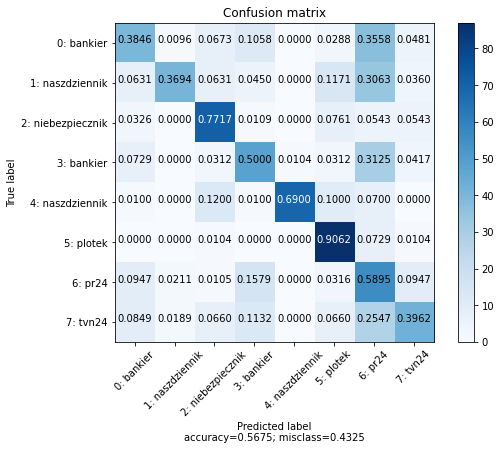

In [102]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier

x_train, x_test, y_train, y_test = train_test_split(df['title'], df['portal_id'], test_size=0.3333, random_state=42)


text_clf = Pipeline([('vect', TfidfVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVC(decision_function_shape='ovr')),
 ])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_test)
score = text_clf.score(x_test, y_test)

print(metrics.classification_report(y_test, y_pred,digits=3))
['bankier', 'naszdziennik', 'niebezpiecznik', 'onet', 'pcworld', 'plotek', 'pr24', 'tvn24']
confusion_matrix(y_test, y_pred)
plot_confusion_matrix.plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                                            target_names=['0: bankier', '1: naszdziennik', '2: niebezpiecznik', '3: bankier', '4: naszdziennik', '5: plotek', '6: pr24', '7: tvn24'])

#### Szybki model ze Sklearn - SVM, same nagłówki

              precision    recall  f1-score   support

           0      0.526     0.385     0.444       104
           1      0.891     0.369     0.522       111
           2      0.651     0.772     0.706        92
           3      0.516     0.500     0.508        96
           4      0.986     0.690     0.812       100
           5      0.654     0.906     0.760        96
           6      0.276     0.589     0.376        95
           7      0.600     0.396     0.477       106

    accuracy                          0.568       800
   macro avg      0.638     0.576     0.576       800
weighted avg      0.643     0.568     0.573       800



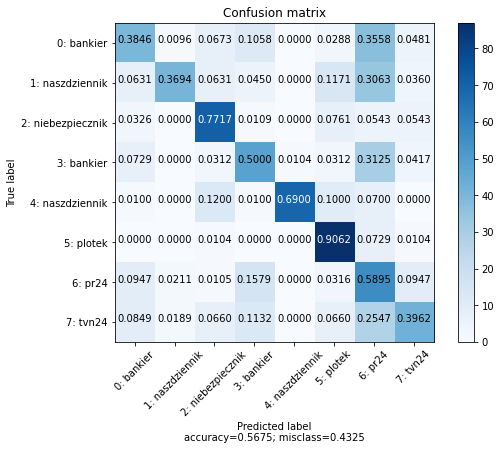

In [103]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier

x_train, x_test, y_train, y_test = train_test_split(df['title'], df['portal_id'], test_size=0.3333, random_state=42)


text_clf = Pipeline([('vect', TfidfVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVC(decision_function_shape='ovr')),
 ])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_test)
score = text_clf.score(x_test, y_test)

print(metrics.classification_report(y_test, y_pred,digits=3))
['bankier', 'naszdziennik', 'niebezpiecznik', 'onet', 'pcworld', 'plotek', 'pr24', 'tvn24']
confusion_matrix(y_test, y_pred)
plot_confusion_matrix.plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                                            target_names=['0: bankier', '1: naszdziennik', '2: niebezpiecznik', '3: bankier', '4: naszdziennik', '5: plotek', '6: pr24', '7: tvn24'])